=== BAYESIAN POISSON REGRESSION - COMPLETE IMPLEMENTATION ===

STEP 1: Helper Functions
--------------------------------------------------
Helper functions defined


STEP 2: Data Preparation
--------------------------------------------------
Number of data points: 30


c:\Users\Petrb\miniconda3\envs\02477_Bayes\Lib\site-packages\jax\_src\numpy\array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Age range: 35.0 to 64.0
Deaths range: 1 to 19
Design matrix shape: (30, 2)
Prediction matrix shape: (100, 2)


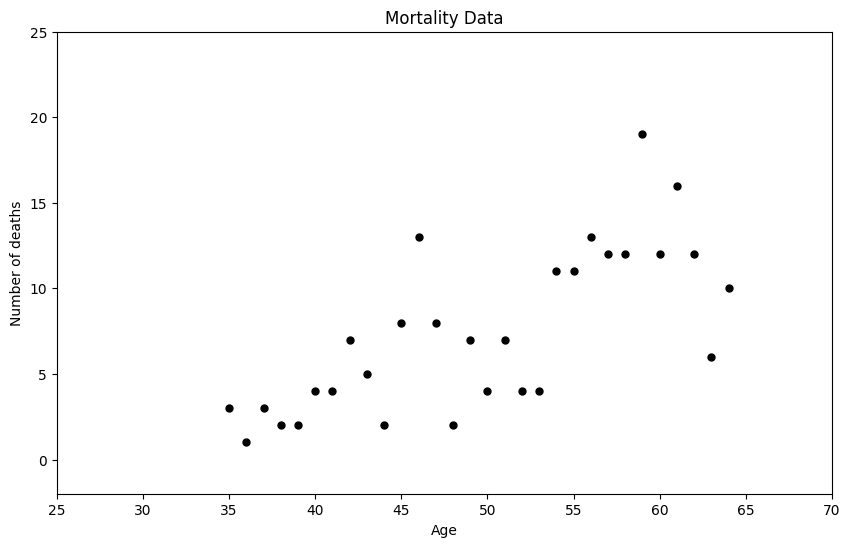



STEP 3: Model Definition
--------------------------------------------------
Model structure:
  y_n | μ_n ~ Poisson(μ_n)
  μ_n = exp(f_n)
  f_n = w_0 + w_1 * x_n
  w | κ ~ N(0, κ²I)
  κ ~ N_+(0, 1)


STEP 4: Hand Calculation Example
--------------------------------------------------
Small example with 3 data points:
X_small:
[[ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]
y_small: [3 4 5]

Example parameters:
w = [1.  0.5]
κ = 1.0

Linear predictor f = Xw:
f = [0.5 1.  1.5]

Mean μ = exp(f):
μ = [1.6487212 2.7182817 4.481689 ]

Log likelihood:
  n=0: log P(y=3 | μ=1.649) = -1.940
  n=1: log P(y=4 | μ=2.718) = -1.896
  n=2: log P(y=5 | μ=4.482) = -1.769
Total: -5.606

Log prior on w:
log p(w | κ) = -2.463

Log hyperprior on κ:
log p(κ) = -0.726

Total log joint:
log p(y, w, κ) = -8.795


STEP 5: Log Joint Distribution Implementation
--------------------------------------------------
Test evaluation at θ = [0. 0. 1.]
log p(y, w, κ) = -358.135


STEP 6: MCMC Sampling
----------------------------------

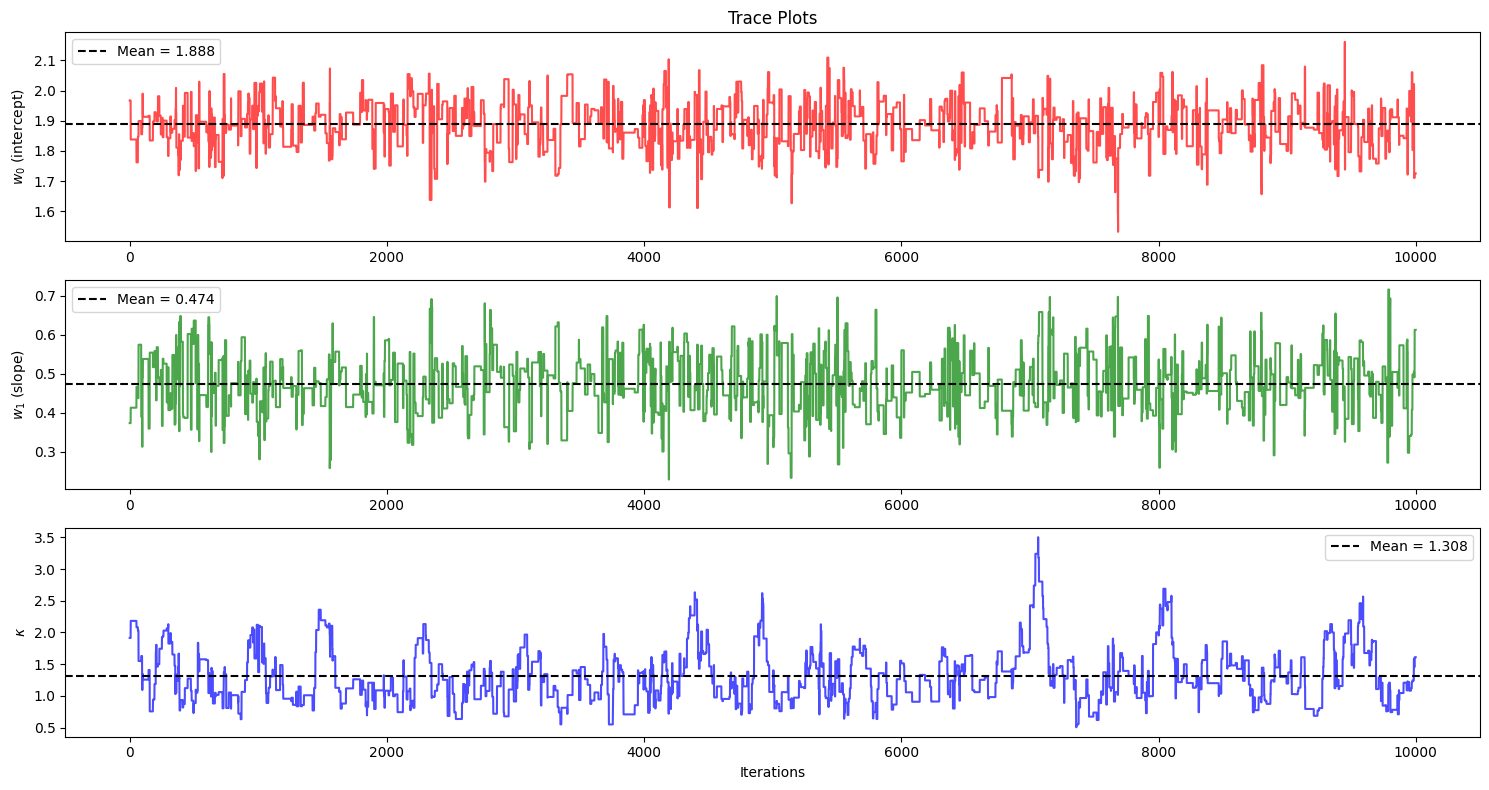



STEP 8: Prior-Posterior Comparison
--------------------------------------------------


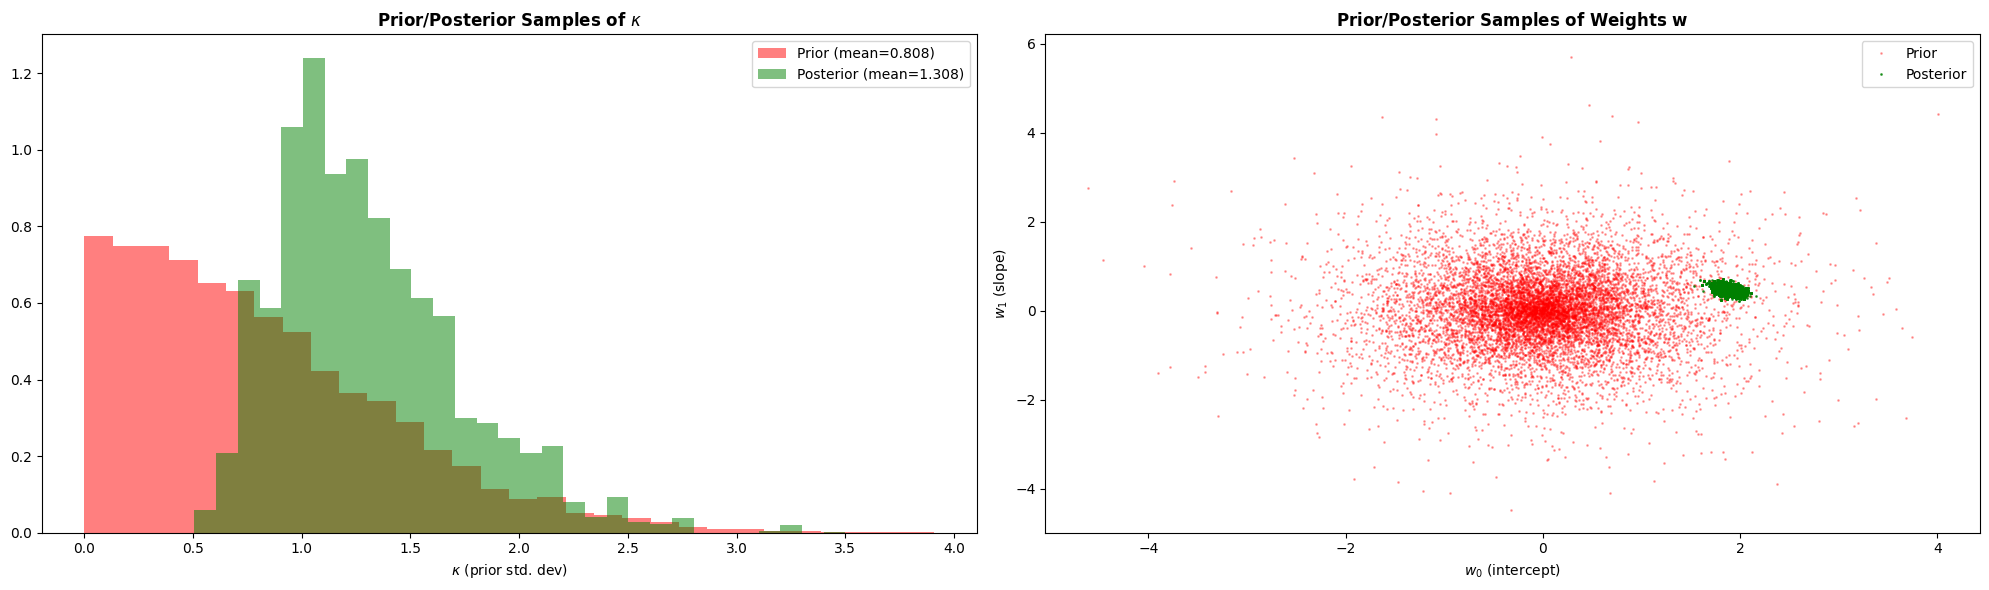



STEP 9: Posterior Predictive Distribution
--------------------------------------------------
Computing posterior predictive samples...
f* samples shape: (100, 10000)
μ* samples shape: (100, 10000)
y* samples shape: (100, 10000)


ValueError: x and y must have same first dimension, but have shapes (100,) and (10000,)

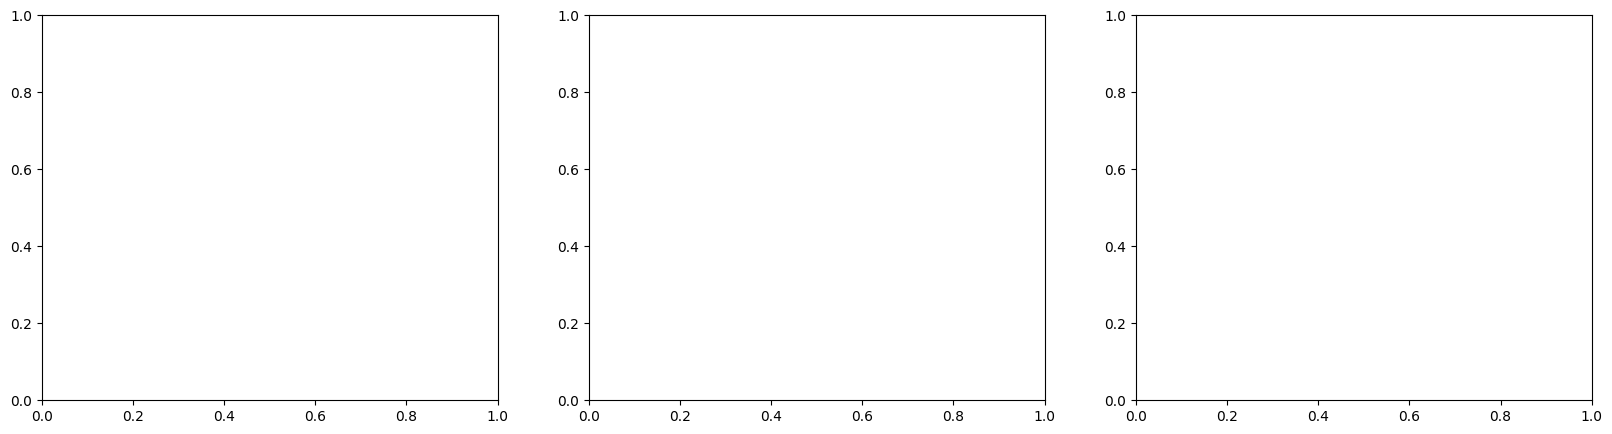

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import halfnorm, poisson, norm
import jax.random as random

print("=== BAYESIAN POISSON REGRESSION - COMPLETE IMPLEMENTATION ===\n")

# =============================================================================
# STEP 1: Helper Functions
# =============================================================================
print("STEP 1: Helper Functions")
print("-" * 50)

def log_npdf(x, m, v):
    """Log of normal probability density function"""
    return -0.5*(x-m)**2/v - 0.5*jnp.log(2*jnp.pi*v)

def log_half_npdf(x, m, v):
    """Log of half-normal probability density function"""
    if x < 0:
        return -jnp.inf
    return jnp.log(jnp.sqrt(2/jnp.pi)) - 0.5*(x-m)**2/v

# Metropolis-Hastings implementation
def metropolis(log_target, num_params, step_size, num_iter=10000, theta_init=None):
    """Simple Metropolis algorithm with Gaussian proposals"""
    if theta_init is None:
        theta_init = np.zeros(num_params)
    
    # Storage
    samples = np.zeros((num_iter, num_params))
    current_theta = theta_init
    current_log_prob = log_target(current_theta)
    
    # Acceptance tracking
    n_accepted = 0
    
    for i in range(num_iter):
        # Propose new state
        proposal = current_theta + step_size * np.random.randn(num_params)
        
        # Compute acceptance ratio
        proposal_log_prob = log_target(proposal)
        log_ratio = proposal_log_prob - current_log_prob
        
        # Accept/reject
        if np.log(np.random.rand()) < log_ratio:
            current_theta = proposal
            current_log_prob = proposal_log_prob
            n_accepted += 1
        
        samples[i] = current_theta
    
    print(f"Acceptance rate: {n_accepted/num_iter:.3f}")
    return samples

print("Helper functions defined")

# =============================================================================
# STEP 2: Data Preparation
# =============================================================================
print("\n\nSTEP 2: Data Preparation")
print("-" * 50)

# Raw data
age = jnp.arange(35, 65).astype(jnp.float64)
deaths = jnp.array([3, 1, 3, 2, 2, 4, 4, 7, 5, 2, 8, 13, 8, 2, 7, 4, 7, 4, 4, 
                   11, 11, 13, 12, 12, 19, 12, 16, 12, 6, 10])

# Number of data points
N = len(deaths)
print(f"Number of data points: {N}")
print(f"Age range: {age[0]} to {age[-1]}")
print(f"Deaths range: {deaths.min()} to {deaths.max()}")

# Standardize input
m_age = jnp.mean(age)
s_age = jnp.std(age)
standardize = lambda x: (x - m_age) / s_age

x = standardize(age)[:, None]

# Define prediction points
age_star = jnp.linspace(25, 70, 100)
x_star = standardize(age_star)

# Design matrices
design_matrix = lambda x: jnp.column_stack((jnp.ones(len(x)), x))
X_train = design_matrix(x)
X_star = design_matrix(x_star)

print(f"Design matrix shape: {X_train.shape}")
print(f"Prediction matrix shape: {X_star.shape}")

# Plotting function
def plot_data(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(age, deaths, 'k.', markersize=10)
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of deaths')
    ax.set_xlim((25, 70))
    ax.set_ylim((-2, 25))
    return ax

# Plot raw data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax)
ax.set_title('Mortality Data')
plt.show()

# =============================================================================
# STEP 3: Define the Model
# =============================================================================
print("\n\nSTEP 3: Model Definition")
print("-" * 50)

print("Model structure:")
print("  y_n | μ_n ~ Poisson(μ_n)")
print("  μ_n = exp(f_n)")
print("  f_n = w_0 + w_1 * x_n")
print("  w | κ ~ N(0, κ²I)")
print("  κ ~ N_+(0, 1)")

# =============================================================================
# STEP 4: Hand Calculation Example
# =============================================================================
print("\n\nSTEP 4: Hand Calculation Example")
print("-" * 50)

# Small example with 3 data points
print("Small example with 3 data points:")
x_small = jnp.array([[-1], [0], [1]])  # Standardized ages
y_small = jnp.array([3, 4, 5])         # Deaths
X_small = design_matrix(x_small[:, 0])

print(f"X_small:\n{X_small}")
print(f"y_small: {y_small}")

# Example parameters
w_ex = jnp.array([1.0, 0.5])
kappa_ex = 1.0
print(f"\nExample parameters:")
print(f"w = {w_ex}")
print(f"κ = {kappa_ex}")

# Compute f
f_ex = X_small @ w_ex
print(f"\nLinear predictor f = Xw:")
print(f"f = {f_ex}")

# Compute μ
mu_ex = jnp.exp(f_ex)
print(f"\nMean μ = exp(f):")
print(f"μ = {mu_ex}")

# Compute log likelihood
log_lik_ex = jnp.sum(poisson.logpmf(y_small, mu_ex))
print(f"\nLog likelihood:")
for i in range(3):
    term = poisson.logpmf(y_small[i], mu_ex[i])
    print(f"  n={i}: log P(y={y_small[i]} | μ={mu_ex[i]:.3f}) = {term:.3f}")
print(f"Total: {log_lik_ex:.3f}")

# Compute log prior on w
log_prior_w_ex = jnp.sum(log_npdf(w_ex, 0, kappa_ex**2))
print(f"\nLog prior on w:")
print(f"log p(w | κ) = {log_prior_w_ex:.3f}")

# Compute log hyperprior on κ
log_hyperprior_ex = log_half_npdf(kappa_ex, 0, 1)
print(f"\nLog hyperprior on κ:")
print(f"log p(κ) = {log_hyperprior_ex:.3f}")

# Total log joint
log_joint_ex = log_lik_ex + log_prior_w_ex + log_hyperprior_ex
print(f"\nTotal log joint:")
print(f"log p(y, w, κ) = {log_joint_ex:.3f}")

# =============================================================================
# STEP 5: Implement Log Joint Distribution
# =============================================================================
print("\n\nSTEP 5: Log Joint Distribution Implementation")
print("-" * 50)

num_params = 3

def log_joint_poisson(theta):
    """
    Computes the log joint distribution for the Poisson regression model.
    theta = [w_0, w_1, κ]
    """
    # Extract parameters
    w = theta[:2]
    kappa = theta[2]
    
    # Check constraint κ > 0
    if kappa < 0:
        return -jnp.inf
    
    # Log hyperprior p(κ)
    log_hyperprior = log_half_npdf(kappa, 0, 1)
    
    # Log prior p(w | κ)
    log_prior = jnp.sum(log_npdf(w, 0, kappa**2))
    
    # Log likelihood p(y | w)
    f = X_train @ w
    mu = jnp.exp(f)
    log_likelihood = jnp.sum(poisson.logpmf(deaths, mu))
    
    return log_likelihood + log_prior + log_hyperprior

# Test the function
theta_test = jnp.array([0., 0., 1.])
log_joint_test = log_joint_poisson(theta_test)
print(f"Test evaluation at θ = {theta_test}")
print(f"log p(y, w, κ) = {log_joint_test:.3f}")

# =============================================================================
# STEP 6: MCMC Sampling
# =============================================================================
print("\n\nSTEP 6: MCMC Sampling")
print("-" * 50)

# MCMC parameters
num_iter = 20000
warm_up = int(0.5 * num_iter)
step_size = 0.3

print(f"MCMC iterations: {num_iter}")
print(f"Warm-up samples: {warm_up}")
print(f"Step size: {step_size}")

# Run Metropolis-Hastings
print("\nRunning Metropolis-Hastings...")
thetas_poisson = metropolis(log_joint_poisson, num_params, step_size, 
                           num_iter=num_iter, theta_init=np.array([0, 0, 1]))

# Remove warm-up samples
thetas_poisson = thetas_poisson[warm_up:, :]

# Extract samples
w_samples = thetas_poisson[:, :2]
kappa_samples = thetas_poisson[:, 2]

print(f"Final sample size: {len(w_samples)}")

# =============================================================================
# STEP 7: Trace Plots
# =============================================================================
print("\n\nSTEP 7: Trace Plots")
print("-" * 50)

fig, axes = plt.subplots(3, 1, figsize=(15, 8))

axes[0].plot(w_samples[:, 0], 'r-', alpha=0.7)
axes[0].set(ylabel='$w_0$ (intercept)', title='Trace Plots')
axes[0].axhline(w_samples[:, 0].mean(), color='k', linestyle='--', 
               label=f'Mean = {w_samples[:, 0].mean():.3f}')
axes[0].legend()

axes[1].plot(w_samples[:, 1], 'g-', alpha=0.7)
axes[1].set(ylabel='$w_1$ (slope)')
axes[1].axhline(w_samples[:, 1].mean(), color='k', linestyle='--',
               label=f'Mean = {w_samples[:, 1].mean():.3f}')
axes[1].legend()

axes[2].plot(kappa_samples, 'b-', alpha=0.7)
axes[2].set(ylabel='$\\kappa$', xlabel='Iterations')
axes[2].axhline(kappa_samples.mean(), color='k', linestyle='--',
               label=f'Mean = {kappa_samples.mean():.3f}')
axes[2].legend()

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 8: Prior-Posterior Comparison
# =============================================================================
print("\n\nSTEP 8: Prior-Posterior Comparison")
print("-" * 50)

S = len(kappa_samples)

# Generate prior samples
key = random.PRNGKey(1)
key_kappa, key_w = random.split(key, num=2)

# Prior samples for κ
kappa_prior_samples = np.abs(random.normal(key_kappa, shape=(S,)))

# Prior samples for w | κ
w_prior_samples = jnp.sqrt(kappa_prior_samples[:, None]) * random.normal(key_w, shape=(S, 2))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# κ samples
axes[0].hist(kappa_prior_samples, 30, density=True, color='r', alpha=0.5, 
            label=f'Prior (mean={kappa_prior_samples.mean():.3f})')
axes[0].hist(kappa_samples, 30, density=True, color='g', alpha=0.5, 
            label=f'Posterior (mean={kappa_samples.mean():.3f})')
axes[0].set_xlabel('$\\kappa$ (prior std. dev)')
axes[0].set_title('Prior/Posterior Samples of $\\kappa$', fontweight='bold')
axes[0].legend()

# Weight samples
axes[1].plot(w_prior_samples[:, 0], w_prior_samples[:, 1], 'r.', alpha=0.3, 
            label='Prior', markersize=2)
axes[1].plot(w_samples[:, 0], w_samples[:, 1], 'g.', alpha=0.7,
            label='Posterior', markersize=2)
axes[1].set_xlabel('$w_0$ (intercept)')
axes[1].set_ylabel('$w_1$ (slope)')
axes[1].set_title('Prior/Posterior Samples of Weights $\\mathbf{w}$', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 9: Posterior Predictive Distribution
# =============================================================================
print("\n\nSTEP 9: Posterior Predictive Distribution")
print("-" * 50)

# Making predictions
print("Computing posterior predictive samples...")

# f* = w^T x*
f_star_samples = X_star @ w_samples.T  # Shape: (100, S)

# μ* = exp(f*)
mu_star_samples = np.exp(f_star_samples)

# y* ~ Poisson(μ*)
key_pred = random.PRNGKey(42)
y_star_samples = np.random.poisson(mu_star_samples)

print(f"f* samples shape: {f_star_samples.shape}")
print(f"μ* samples shape: {mu_star_samples.shape}")
print(f"y* samples shape: {y_star_samples.shape}")

# Helper function for plotting predictions
def plot_predictions(ax, x_vals, samples, num_samples=50, alpha=0.01, 
                    color='blue', legend=True, title=''):
    """Plot predictive samples with uncertainty bands"""
    # Plot individual samples
    if num_samples > 0:
        idx = np.random.choice(samples.shape[1], size=min(num_samples, samples.shape[1]), 
                              replace=False)
        for i in idx:
            ax.plot(x_vals, samples[:, i], color=color, alpha=alpha)
    
    # Plot mean and credible intervals
    mean_pred = np.mean(samples, axis=1)
    lower = np.percentile(samples, 2.5, axis=1)
    upper = np.percentile(samples, 97.5, axis=1)
    
    ax.plot(x_vals, mean_pred, color='black', linewidth=2, label='Mean')
    ax.fill_between(x_vals, lower, upper, alpha=0.3, color=color, 
                   label='95% Credible Interval')
    
    if legend:
        ax.legend()
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Age')

# Plot all posterior predictive distributions
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_predictions(axes[0], age_star, f_star_samples.T, num_samples=100, 
                alpha=0.05, color='blue', legend=True, 
                title='Posterior of $f_*|\\mathbf{y}$')
axes[0].set_ylabel('Linear Predictor $f$')

plot_predictions(axes[1], age_star, mu_star_samples.T, num_samples=100, 
                alpha=0.05, color='green', legend=True, 
                title='Posterior of $\\mu_*|\\mathbf{y}$')
plot_data(axes[1])
axes[1].set_ylabel('Expected Deaths $\\mu$')

plot_predictions(axes[2], age_star, y_star_samples.T, num_samples=0, 
                alpha=0.05, color='red', legend=True, 
                title='Predictive Distribution $y_*|\\mathbf{y}$')
plot_data(axes[2])
axes[2].set_ylabel('Predicted Deaths $y$')

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 10: Prediction at Age 75
# =============================================================================
print("\n\nSTEP 10: Prediction at Age 75")
print("-" * 50)

# Prepare input for age 75
age_75 = 75
x_75 = standardize(age_75)
X_75 = np.array([1, x_75])

print(f"Age 75 standardized: {x_75:.3f}")
print(f"Design vector: {X_75}")

# Compute predictions
f_75 = X_75 @ w_samples.T
mu_75 = np.exp(f_75)

# Sample from predictive distribution
key_75 = random.PRNGKey(1234)
y_75 = random.poisson(key_75, mu_75)

print(f"\nPosterior predictive statistics for age 75:")
print(f"E[f | y] = {f_75.mean():.3f} ± {f_75.std():.3f}")
print(f"E[μ | y] = {mu_75.mean():.3f} ± {mu_75.std():.3f}")
print(f"E[y | y] = {y_75.mean():.3f} ± {y_75.std():.3f}")

# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (name, values, color) in enumerate(zip(
    ['$f^*$ for age=75', '$\\mu^*$ for age=75', '$y^*$ for age=75'],
    [f_75, mu_75, y_75],
    ['blue', 'green', 'red'])):
    
    axes[i].hist(values, 30, density=True, alpha=0.7, color=color)
    axes[i].axvline(values.mean(), color='black', linestyle='--', linewidth=2,
                   label=f'Mean = {values.mean():.2f}')
    axes[i].axvline(np.percentile(values, 2.5), color='black', linestyle=':', 
                   label='95% CI')
    axes[i].axvline(np.percentile(values, 97.5), color='black', linestyle=':')
    axes[i].set_xlabel(name)
    axes[i].set_title(f'Posterior Predictive: {name}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 11: Model Diagnostics
# =============================================================================
print("\n\nSTEP 11: Model Diagnostics")
print("-" * 50)

# Effective sample size (simple approximation)
def effective_sample_size(x):
    """Compute effective sample size using autocorrelation"""
    n = len(x)
    # Compute autocorrelation
    x_centered = x - x.mean()
    c0 = np.dot(x_centered, x_centered) / n
    
    # Find first negative autocorrelation
    sum_autocorr = 1.0
    for k in range(1, min(n//4, 1000)):
        ck = np.dot(x_centered[:-k], x_centered[k:]) / (n - k)
        rho_k = ck / c0
        if rho_k < 0:
            break
        sum_autocorr += 2 * rho_k
    
    return n / sum_autocorr

# Compute effective sample sizes
ess_w0 = effective_sample_size(w_samples[:, 0])
ess_w1 = effective_sample_size(w_samples[:, 1])
ess_kappa = effective_sample_size(kappa_samples)

print(f"Effective sample sizes:")
print(f"  w_0: {ess_w0:.0f} ({100*ess_w0/len(w_samples):.1f}%)")
print(f"  w_1: {ess_w1:.0f} ({100*ess_w1/len(w_samples):.1f}%)")
print(f"  κ:   {ess_kappa:.0f} ({100*ess_kappa/len(kappa_samples):.1f}%)")

# Posterior correlations
corr_matrix = np.corrcoef(thetas_poisson.T)
print(f"\nPosterior correlation matrix:")
print(f"     w_0    w_1     κ")
print(f"w_0  {corr_matrix[0,0]:.3f} {corr_matrix[0,1]:.3f} {corr_matrix[0,2]:.3f}")
print(f"w_1  {corr_matrix[1,0]:.3f} {corr_matrix[1,1]:.3f} {corr_matrix[1,2]:.3f}")
print(f"κ    {corr_matrix[2,0]:.3f} {corr_matrix[2,1]:.3f} {corr_matrix[2,2]:.3f}")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n\n=== SUMMARY ===")
print("-" * 50)
print(f"Model: Bayesian Poisson Regression")
print(f"Data: {N} observations of mortality by age")
print(f"Parameters: intercept w_0, slope w_1, hyperparameter κ")
print(f"MCMC: {num_iter} iterations, {num_iter - warm_up} samples after warm-up")
print(f"\nPosterior means:")
print(f"  w_0 = {w_samples[:, 0].mean():.3f} ± {w_samples[:, 0].std():.3f}")
print(f"  w_1 = {w_samples[:, 1].mean():.3f} ± {w_samples[:, 1].std():.3f}")
print(f"  κ   = {kappa_samples.mean():.3f} ± {kappa_samples.std():.3f}")
print(f"\nInterpretation:")
print(f"  - Positive slope indicates mortality increases with age")
print(f"  - Posterior is concentrated compared to prior")
print(f"  - Model captures the exponential growth in mortality")